# Основная информация по отчету

Выполнил - Светлов Ярослав Геннадьевич, 467390, ИИИ 1.1

# Ход работы 

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
from typing import Tuple, List, Dict
import time

## Загрузка изображения
Загружаем изображение и разделяем на каналы.
Нормализуем значения каналов к диапазону [0, 1], если они загрузились как uint8 (0-255).

Image loaded. Dimensions: (600, 800, 3), dtype: uint8
Image normalized to [0, 1] float range.
Size of channel R: (600, 800)
Size of channel G: (600, 800)
Size of channel B: (600, 800)


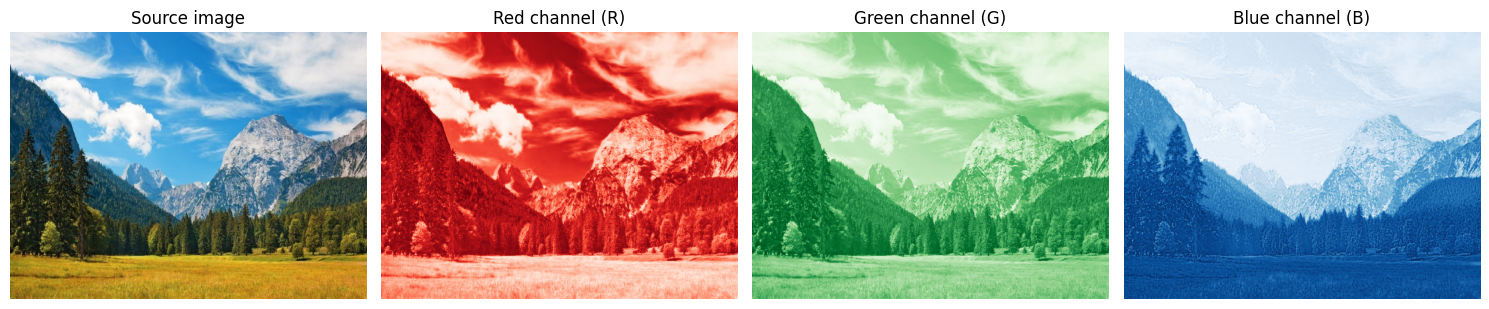


Channels R, G, B have been successfully extracted and are ready for further processing.


In [2]:
image_path = 'bavarskie_alpi.jpg'

img = mpimg.imread(image_path)

print(f"Image loaded. Dimensions: {img.shape}, dtype: {img.dtype}")

if img.dtype == np.uint8:
    img = img / 255.0
    print("Image normalized to [0, 1] float range.")

R_channel = img[:, :, 0].astype(float)
G_channel = img[:, :, 1].astype(float)
B_channel = img[:, :, 2].astype(float)
print(f"Size of channel R: {R_channel.shape}")
print(f"Size of channel G: {G_channel.shape}")
print(f"Size of channel B: {B_channel.shape}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Source image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(R_channel, cmap='Reds_r')
plt.title('Red channel (R)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(G_channel, cmap='Greens_r')
plt.title('Green channel (G)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(B_channel, cmap='Blues_r')
plt.title('Blue channel (B)')
plt.axis('off')

plt.tight_layout()
plt.show()

print("\nChannels R, G, B have been successfully extracted and are ready for further processing.")

## 1. & 2. Сингулярное разложение степенным методом
Функция `power_iteration` находит доминирующее собственное значение и соответствующий ему собственный вектор.
Функция `svd_via_power` использует `power_iteration` итеративно с дефляцией для нахождения нескольких сингулярных троек.

**Пояснения работы алгоритма степенного метода:**

1.  Задаётся случайный вектор $x$ размерности n (или m, в зависимости от того, для какой матрицы ищем СЗ) и нормируется.
2.  На каждой итерации вычисляется произведение $y = M \cdot x$, где $M = A^T A$ или $M = A A^T$.
3.  Собственное значение на данном шаге аппроксимируется как норма вектора $y$:
    $$
      \lambda = \|y\|_2.
    $$
    Или, что более устойчиво, через отношение Рэлея: $\lambda = x^T M x$.
4.  Новый вектор $x$ нормируется:
    $$
      x = \frac{y}{\|y\|_2}.
    $$
    (Примечание: в коде используется $\lambda$ из отношения Рэлея, а $x$ нормируется делением на $\|y\|_2$, что эквивалентно $y / \text{eigenvalue}$ если eigenvalue это $\|y\|_2$).
5.  Проверяется разница между новыми и старыми значениями $\lambda$. Если она меньше допуска $tol$, итерации останавливаются.
6.  В конце возвращаются последнее приближение собственного вектора $x$ и значение $\lambda$.

Этот метод хорошо работает для матриц, у которых есть единственное по модулю наибольшее собственное значение. Для нахождения других собственных значений и векторов используется техника дефляции.
Сингулярные числа $\sigma_i$ матрицы $A$ являются квадратными корнями из собственных значений матрицы $A^T A$ (или $A A^T$). Соответствующие сингулярные векторы $v_i$ (столбцы $V$) являются собственными векторами $A^T A$, а $u_i$ (столбцы $U$) вычисляются как $u_i = \frac{1}{\sigma_i} A v_i$.

In [3]:
def power_iteration(M: np.ndarray, N: int, tol=1e-10) -> Tuple[np.ndarray, float]:
    n_dim = M.shape[0]

    x = np.random.rand(n_dim)
    x = x / np.linalg.norm(x)

    eigenvalue_old = 0.0
    eigenvalue = 0.0

    for i in range(N):
        y = M @ x
        eigenvalue = x.T @ y

        norm_y = np.linalg.norm(y)
        if norm_y < tol:
            eigenvalue = 0.0
            break
        else:
            x = y / norm_y

        if np.abs(eigenvalue - eigenvalue_old) < tol and i > 0:
            break
        eigenvalue_old = eigenvalue
    return x, eigenvalue

In [4]:
def get_sigma_u(matrix: np.ndarray, v: np.ndarray, eig_val_M: float) -> Tuple[float, np.ndarray]:

    if eig_val_M < 0:
        # Отрицательные значения - результат численных ошибок.
        eig_val_M = abs(eig_val_M)

    sigma = np.sqrt(eig_val_M)

    if sigma < 1e-10:
        # Если сингулярное число очень мало, u вектор может быть нестабилен или не определен.
        return 0.0, np.zeros_like(matrix[:, 0])

    u = (matrix @ v) / sigma
    norm_u = np.linalg.norm(u)
    if norm_u > 1e-10:
        u = u / norm_u  # Нормализация u
    else:
        return sigma, np.zeros_like(matrix[:, 0])  # Если u оказался нулевым

    return sigma, u

In [5]:
def svd_via_power(A: np.ndarray, num_components: int, N_iter_power: int) -> Tuple[List[float], np.ndarray, np.ndarray]:
    m, n = A.shape
    S_list: List[float] = []
    U_cols_list: List[np.ndarray] = []
    V_cols_list: List[np.ndarray] = []

    A_residual = A.copy()

    rank_A = min(m, n)
    num_components = min(num_components, rank_A)

    for i in range(num_components):
        if m >= n:  # A.T @ A (n x n) - ищем v, потом u
            M = A_residual.T @ A_residual
            v_i, lambda_i = power_iteration(M, N_iter_power)


            if lambda_i < 0:  # Маленькое отрицательное из-за ошибок округления
                lambda_i = 0.0

            sigma_i = np.sqrt(lambda_i)

            if sigma_i < 1e-10:
                break  # Сингулярные числа стали слишком малы

            # Расчет u_i из A_residual и v_i
            Av = A_residual @ v_i
            norm_Av = np.linalg.norm(Av)
            if norm_Av < 1e-10:  # Если A_residual @ v_i почти ноль
                u_i = np.zeros(m)
            else:
                u_i = Av / norm_Av

        else:  # A @ A.T (m x m) - ищем u, потом v
            M = A_residual @ A_residual.T
            u_i, lambda_i = power_iteration(M, N_iter_power)

            if lambda_i < 0:
                lambda_i = 0.0

            sigma_i = np.sqrt(lambda_i)

            if sigma_i < 1e-10:
                break

            # Расчет v_i из A_residual.T и u_i
            A_T_u = A_residual.T @ u_i
            norm_A_T_u = np.linalg.norm(A_T_u)
            if norm_A_T_u < 1e-10:
                v_i = np.zeros(n)
            else:
                v_i = A_T_u / norm_A_T_u

        S_list.append(sigma_i)
        U_cols_list.append(u_i)
        V_cols_list.append(v_i)

        A_residual = A_residual - sigma_i * np.outer(u_i, v_i)  # Дефляция

        if np.linalg.norm(A_residual) < 1e-9:
            break

    if not S_list:
        return [], np.empty((m, 0)), np.empty((n, 0))

    U_matrix = np.stack(U_cols_list, axis=1)
    Vt_matrix = np.stack(V_cols_list, axis=1).T

    return S_list, U_matrix, Vt_matrix

### Применение степенного метода для каналов R, G, B
Задаем число итераций N для степенного метода: {10, 50, 100}.
Для каждого случая (R, G, B) сравниваем результаты.
Число сингулярных компонент для расчета возьмем, например, 50 или 100.

In [6]:
N_iterations_list = [10, 50, 100]
channels = {'R': R_channel, 'G': G_channel, 'B': B_channel}
results_power_method = {}

num_svd_components_to_extract = min(100, R_channel.shape[0], R_channel.shape[1])

print(f"Attempting to extract {num_svd_components_to_extract} singular components using power method.\n")

for N_iter in N_iterations_list:
    print(f"--- Power Method SVD with N_iter = {N_iter} ---")
    results_power_method[N_iter] = {}
    for name, channel_matrix in channels.items():
        print(f"  Processing {name} channel...")
        start_time = time.time()

        S_power, U_power, Vt_power = svd_via_power(channel_matrix,
                                                   num_components=num_svd_components_to_extract,
                                                   N_iter_power=N_iter)

        end_time = time.time()

        Sigma_power_matrix = np.zeros((U_power.shape[1], Vt_power.shape[0]))
        diag_len = min(Sigma_power_matrix.shape[0], Sigma_power_matrix.shape[1], len(S_power))
        np.fill_diagonal(Sigma_power_matrix[:diag_len, :diag_len], S_power[:diag_len])

        reconstructed_matrix = U_power @ Sigma_power_matrix @ Vt_power
        diff_norm = np.linalg.norm(channel_matrix - reconstructed_matrix)

        results_power_method[N_iter][name] = {
            'S': S_power, 'U': U_power, 'Vt': Vt_power,
            'reconstruction_error': diff_norm,
            'time': end_time - start_time
        }

        print(f"    Channel {name}: Time = {end_time - start_time:.2f}s, Norm of difference = {diff_norm:.4f}")
        # Проверка на отрицательные сингулярные числа (S_power не должен их содержать из-за обработки lambda_i)
        if any(s < -1e-9 for s in S_power):  # Проверяем на существенно отрицательные
            print(
                f"    CRITICAL WARNING for channel {name}: Negative singular values detected in final S_power list! This indicates a bug.")
            negative_s_values = [s for s in S_power if s < 0]
            print(f"    Actual negative S values: {negative_s_values}")
        # Пояснения по отрицательным собственным значениям lambda (которые могут приводить к проблемам с sigma)
        # даны в Markdown ячейке ниже.
    print("-" * 30)

Attempting to extract 100 singular components using power method.

--- Power Method SVD with N_iter = 10 ---
  Processing R channel...
    Channel R: Time = 1.40s, Norm of difference = 20.8736
  Processing G channel...
    Channel G: Time = 1.10s, Norm of difference = 20.1237
  Processing B channel...
    Channel B: Time = 1.15s, Norm of difference = 19.3887
------------------------------
--- Power Method SVD with N_iter = 50 ---
  Processing R channel...
    Channel R: Time = 1.37s, Norm of difference = 20.8479
  Processing G channel...
    Channel G: Time = 1.41s, Norm of difference = 20.0962
  Processing B channel...
    Channel B: Time = 1.43s, Norm of difference = 19.3497
------------------------------
--- Power Method SVD with N_iter = 100 ---
  Processing R channel...
    Channel R: Time = 1.66s, Norm of difference = 20.8488
  Processing G channel...
    Channel G: Time = 1.65s, Norm of difference = 20.0926
  Processing B channel...
    Channel B: Time = 1.77s, Norm of differenc

**Комментарий по отрицательным оценкам сингулярных чисел (точнее, собственных значений $\lambda$ до извлечения корня):**

Сингулярные числа $\sigma_i$ по определению неотрицательны. Они являются квадратными корнями из собственных значений $\lambda_i$ матрицы $A^T A$ (или $A A^T$), которые также всегда неотрицательны.

Если в процессе вычислений степенным методом для матрицы $M=A^T A$ (или $M=A_{\text{residual}}^T A_{\text{residual}}$ после дефляции) мы получаем отрицательную оценку для $\lambda_i$, это указывает на:
1.  **Численные ошибки:** Особенно при работе с числами с плавающей точкой, накопление ошибок может привести к тому, что теоретически неотрицательное значение вычисляется как небольшое отрицательное. Это чаще случается для очень малых собственных значений.
2.  **Недостаточная сходимость:** Степенной метод может не сойтись к истинному собственному значению за заданное число итераций, особенно если есть другие собственные значения, близкие по модулю.
3.  **Проблемы с дефляцией:** Процесс дефляции (вычитания найденных компонент) сам по себе вносит ошибки. После нескольких шагов дефляции матрица $A_{\text{residual}}$ может накопить столько ошибок, что $A_{\text{residual}}^T A_{\text{residual}}$ перестает быть строго положительно полуопределенной в численных расчетах.

В реализованной функции `svd_via_power` есть проверка на отрицательные $\lambda_i$ перед взятием квадратного корня: они принудительно устанавливаются в 0 или берется их модуль. Таким образом, итоговые сингулярные числа в списке `S_power` не должны быть отрицательными. Если предупреждение о отрицательных $\lambda_i$ появляется во время выполнения, это сигнал о вышеупомянутых проблемах на этапе вычисления $\lambda_i$.

## 3. Анализ сингулярных чисел и усеченное SVD
Используем результаты SVD с наибольшим числом итераций (N=100) для анализа.

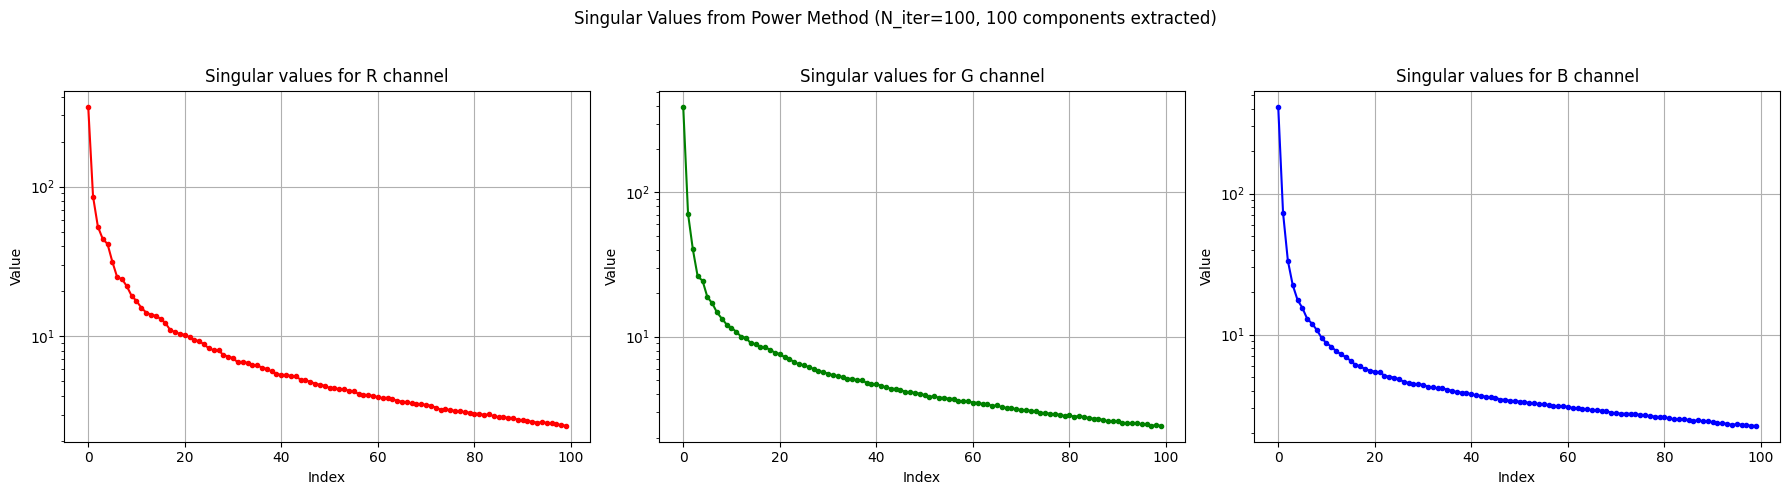

In [7]:
best_N_iter = 100
S_for_analysis_R, S_for_analysis_G, S_for_analysis_B = [], [], []
U_R, Vt_R = np.array([]), np.array([])
U_G, Vt_G = np.array([]), np.array([])
U_B, Vt_B = np.array([]), np.array([])

if best_N_iter not in results_power_method:
    print(f"Warning: Results for N_iter={best_N_iter} not found. Using available N_iter or re-run SVD.")
    if N_iterations_list:
        best_N_iter = N_iterations_list[-1]
        if best_N_iter not in results_power_method:  # Все еще нет
            print("No SVD results available for analysis. Skipping this part.")

if best_N_iter in results_power_method:
    S_for_analysis_R = results_power_method[best_N_iter]['R']['S']
    U_R = results_power_method[best_N_iter]['R']['U']
    Vt_R = results_power_method[best_N_iter]['R']['Vt']

    S_for_analysis_G = results_power_method[best_N_iter]['G']['S']
    U_G = results_power_method[best_N_iter]['G']['U']
    Vt_G = results_power_method[best_N_iter]['G']['Vt']

    S_for_analysis_B = results_power_method[best_N_iter]['B']['S']
    U_B = results_power_method[best_N_iter]['B']['U']
    Vt_B = results_power_method[best_N_iter]['B']['Vt']

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(S_for_analysis_R, 'r.-')
    plt.title('Singular values for R channel')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.semilogy()  # Логарифмическая шкала для лучшей визуализации малых значений

    plt.subplot(1, 3, 2)
    plt.plot(S_for_analysis_G, 'g.-')
    plt.title('Singular values for G channel')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.semilogy()

    plt.subplot(1, 3, 3)
    plt.plot(S_for_analysis_B, 'b.-')
    plt.title('Singular values for B channel')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.semilogy()

    plt.suptitle(
        f'Singular Values from Power Method (N_iter={best_N_iter}, {len(S_for_analysis_R)} components extracted)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("Skipping singular value plots due to missing data.")

**Анализ сингулярных чисел:**

На графиках видно, как быстро убывают сингулярные числа. Большая часть "энергии" (информации) изображения сосредоточена в первых нескольких десятках сингулярных чисел. Логарифмическая шкала по оси Y помогает лучше рассмотреть поведение малых сингулярных чисел.

**Предположение по количеству компонент для усеченного SVD:**

Предположим, что для приемлемого визуального качества потребуется от 20 до 50 старших сингулярных чисел. Точное число зависит от специфики изображения и требуемого уровня детализации и сжатия.

**Проверка предположения - усеченное SVD:**

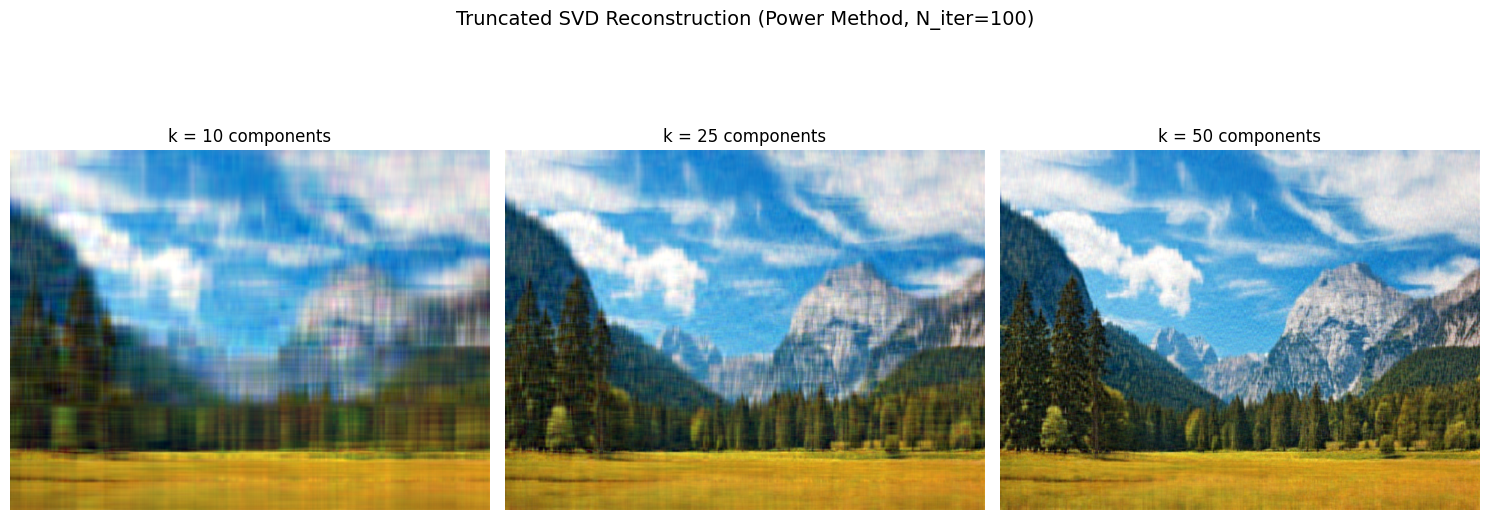

In [8]:
k_values = [k for k in [10, 25, 50] if
            k <= len(S_for_analysis_R) and k > 0 and U_R.shape[1] >= k and U_G.shape[1] >= k and U_B.shape[1] >= k]
if not k_values and len(S_for_analysis_R) > 0:
    k_values = [min(len(S_for_analysis_R), U_R.shape[1], U_G.shape[1], U_B.shape[1])]  # хотя бы одно значение k
    if k_values[0] == 0: k_values = []

if not k_values:
    print("Не удалось извлечь достаточно сингулярных чисел или U/V матриц для усеченного SVD, или k_values пуст.")
else:
    num_plots = len(k_values)
    plt.figure(figsize=(5 * num_plots, 6))  # Увеличена высота для заголовка

    for i, k in enumerate(k_values):
        if k == 0: continue
        # R
        S_k_R = np.diag(S_for_analysis_R[:k])
        U_k_R = U_R[:, :k]
        Vt_k_R = Vt_R[:k, :]
        R_reconstructed_k = U_k_R @ S_k_R @ Vt_k_R

        # G
        S_k_G = np.diag(S_for_analysis_G[:k])
        U_k_G = U_G[:, :k]
        Vt_k_G = Vt_G[:k, :]
        G_reconstructed_k = U_k_G @ S_k_G @ Vt_k_G

        # B
        S_k_B = np.diag(S_for_analysis_B[:k])
        U_k_B = U_B[:, :k]
        Vt_k_B = Vt_B[:k, :]
        B_reconstructed_k = U_k_B @ S_k_B @ Vt_k_B

        reconstructed_img_k = np.stack((R_reconstructed_k, G_reconstructed_k, B_reconstructed_k), axis=-1)
        reconstructed_img_k = np.clip(reconstructed_img_k, 0, 1)  # Клиппинг значений

        plt.subplot(1, num_plots, i + 1)
        plt.imshow(reconstructed_img_k)
        plt.title(f'k = {k} components')
        plt.axis('off')

    plt.suptitle(f'Truncated SVD Reconstruction (Power Method, N_iter={best_N_iter})', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Оставляем место для suptitle
    plt.show()


**Визуальная оценка усеченного SVD:**

При $k \approx 50$ качество изображения становится достаточно хорошим. При меньших значениях $k$ (например, 10-25) заметна блочность, потеря деталей или размытие, но основные черты изображения сохраняются. Выбор оптимального $k$ – это компромисс между степенью сжатия (меньше $k$) и качеством восстановления (больше $k$).


## 4. Метод вращений Якоби для SVD
Метод Якоби используется для нахождения собственных значений и векторов симметричной матрицы. Мы применим его к матрице $M = A^T A$.
Собственные значения $M$ - это квадраты сингулярных чисел $A$.
Собственные векторы $M$ - это правые сингулярные векторы $V$ матрицы $A$.
Левые сингулярные векторы $U$ находятся как $U = A V \Sigma^{-1}$.

In [9]:
def jacobi_eigenvalue_method(A_symm: np.ndarray, tol=1e-9, max_sweeps=100):
    n = A_symm.shape[0]
    assert A_symm.shape[0] == A_symm.shape[1], "Матрица должна быть квадратной"
    assert np.allclose(A_symm, A_symm.T), "Матрица должна быть симметричной"

    V_jacobi = np.eye(n)
    D_diag = A_symm.copy()

    for sweep in range(max_sweeps):
        sum_off_diag_sq = np.sum(D_diag[np.triu_indices(n, k=1)] ** 2) * 2

        if sum_off_diag_sq < tol:
            # print(f"Jacobi converged after {sweep} sweeps.") # Для отладки
            break

        for p in range(n):
            for q in range(p + 1, n):
                if abs(D_diag[p, q]) > tol / (n * n):
                    app = D_diag[p, p]
                    aqq = D_diag[q, q]
                    apq = D_diag[p, q]

                    if abs(apq) < 1e-20: continue

                    tau = (aqq - app) / (2 * apq)

                    if tau >= 0:
                        t = 1.0 / (tau + np.sqrt(1 + tau ** 2))
                    else:
                        t = -1.0 / (-tau + np.sqrt(1 + tau ** 2))

                    c = 1.0 / np.sqrt(1 + t ** 2)
                    s = c * t

                    # Обновление D_diag (матрицы D)
                    row_p = D_diag[p, :].copy()
                    row_q = D_diag[q, :].copy()
                    D_diag[p, :] = c * row_p - s * row_q
                    D_diag[q, :] = s * row_p + c * row_q

                    # Симметричное обновление столбцов
                    col_p = D_diag[:, p].copy()
                    col_q = D_diag[:, q].copy()
                    D_diag[:, p] = c * col_p - s * col_q
                    D_diag[:, q] = s * col_p + c * col_q

                    # Обновление матрицы собственных векторов V_jacobi
                    v_col_p = V_jacobi[:, p].copy()
                    v_col_q = V_jacobi[:, q].copy()
                    V_jacobi[:, p] = c * v_col_p - s * v_col_q
                    V_jacobi[:, q] = s * v_col_p + c * v_col_q
        # else: # Для отладки, если не сошлось за max_sweeps
        # if sweep == max_sweeps - 1:
        # print(f"Jacobi reached max_sweeps ({max_sweeps}). Sum off-diag sq: {sum_off_diag_sq:.2e}")

    eigenvalues = np.diag(D_diag)
    idx = np.argsort(eigenvalues)[::-1]  # Сортировка по убыванию
    eigenvalues = eigenvalues[idx]
    eigenvectors = V_jacobi[:, idx]

    return eigenvalues, eigenvectors


def svd_via_jacobi(A: np.ndarray, tol_jacobi=1e-9, max_sweeps_jacobi=100) -> Tuple[List[float], np.ndarray, np.ndarray]:
    m, n = A.shape
    M = A.T @ A  # Формируем A.T @ A (размер n x n)

    lambda_sq, V_jacobi = jacobi_eigenvalue_method(M, tol=tol_jacobi, max_sweeps=max_sweeps_jacobi)

    S_jacobi_list = []
    valid_indices = []
    for i, l_sq in enumerate(lambda_sq):
        if l_sq > 1e-12:  # Учитываем только положительные собственные значения
            S_jacobi_list.append(np.sqrt(l_sq))
            valid_indices.append(i)
        # elif l_sq < -1e-9: # Можно добавить предупреждение для сильно отрицательных lambda
        # print(f"Warning: Jacobi method resulted in a significant negative eigenvalue for A.T@A: {l_sq:.2e}")

    S_jacobi_arr = np.array(S_jacobi_list)
    V_jacobi_filtered = V_jacobi[:, valid_indices]

    if S_jacobi_arr.size == 0:  # Если не найдено положительных сингулярных чисел
        return [], np.empty((m, 0)), np.empty((n, 0))

    # U = A V S_inv (для отобранных V и S)
    U_jacobi = (A @ V_jacobi_filtered) @ np.diag(1.0 / S_jacobi_arr)

    return S_jacobi_arr.tolist(), U_jacobi, V_jacobi_filtered.T  # Возвращаем Vt

### Применение метода Якоби
Выберем один канал, например R, и найдем его сингулярные числа. Сравним с результатами степенного метода.
Метод Якоби может быть медленным для больших матриц (например, если ширина/высота > 200-300 пикселей).
Для демонстрации можно взять уменьшенную версию канала или быть готовым подождать.

In [10]:
channel_to_test_comparison = R_channel # Исходный R канал
channel_name_comparison = 'R'


max_dim_test = 300 
h_orig, w_orig = channel_to_test_comparison.shape
test_matrix_for_comparison = channel_to_test_comparison[:min(h_orig, max_dim_test), :min(w_orig, max_dim_test)]

print(f"--- Сравнение SVD методов на матрице канала {channel_name_comparison} размером {test_matrix_for_comparison.shape} ---")

# 1. Метод Якоби на тестовой матрице
print(f"\n1. Запуск SVD методом Якоби...")
start_time_jacobi = time.time()
S_jacobi_test, U_jacobi_test, Vt_jacobi_test = svd_via_jacobi(test_matrix_for_comparison,
                                                              tol_jacobi=1e-10,
                                                              max_sweeps_jacobi=100)
end_time_jacobi = time.time()
time_taken_jacobi = end_time_jacobi - start_time_jacobi
print(f"  Время SVD методом Якоби: {time_taken_jacobi:.2f}s")
print(f"  Найдено {len(S_jacobi_test)} сингулярных чисел методом Якоби.")

# 2. Степенной метод на той же тестовой матрице
# Используем N_iter=100 (как best_N_iter) и извлекаем все возможные компоненты для этой небольшой матрицы
num_components_power_test = min(test_matrix_for_comparison.shape)
print(f"\n2. Запуск SVD степенным методом (N_iter={best_N_iter}, {num_components_power_test} компонент)...")
start_time_power = time.time()
S_power_test, U_power_test, Vt_power_test = svd_via_power(test_matrix_for_comparison,
                                                          num_components=num_components_power_test,
                                                          N_iter_power=best_N_iter) # best_N_iter обычно 100
end_time_power = time.time()
time_taken_power = end_time_power - start_time_power
print(f"  Время SVD степенным методом: {time_taken_power:.2f}s")
print(f"  Найдено {len(S_power_test)} сингулярных чисел степенным методом.")

# 3. Сравнение сингулярных чисел
print(f"\n3. Сравнение сингулярных чисел (Якоби vs Степенной метод) для матрицы {test_matrix_for_comparison.shape}:")
num_to_compare = min(len(S_jacobi_test), len(S_power_test), 20) # Сравним первые 20 или сколько есть


print("  Idx | Jacobi  | Power   | Diff (abs) | Diff (%)")
print("  ------------------------------------------------------")
for i in range(num_to_compare):
    s_j = S_jacobi_test[i]
    s_p = S_power_test[i]
    diff_abs = abs(s_j - s_p)
    diff_percent = (diff_abs / max(s_j, 1e-9)) * 100 # Процентная разница (избегаем деления на ноль)
    print(f"  {i:3d} | {s_j:9.4f} | {s_p:9.4f} | {diff_abs:10.4f} | {diff_percent:8.2f}%")

# Средняя относительная ошибка для сравненных чисел
if num_to_compare > 0:
    relative_errors = [abs(S_jacobi_test[i] - S_power_test[i]) / max(S_jacobi_test[i], 1e-9)
                       for i in range(min(len(S_jacobi_test), len(S_power_test)))] # по всем доступным парам
    mean_relative_error = np.mean(relative_errors[:num_to_compare]) * 100
    print(f"\n  Средняя относительная ошибка для первых {num_to_compare} сингулярных чисел: {mean_relative_error:.2f}%")

# 4. Сравнение с np.linalg.svd как "эталоном" на той же тестовой матрице
print(f"\n4. Сравнение с np.linalg.svd (эталон) для матрицы {test_matrix_for_comparison.shape}:")
start_time_numpy = time.time()
U_np, S_np, Vt_np = np.linalg.svd(test_matrix_for_comparison)
end_time_numpy = time.time()
time_taken_numpy = end_time_numpy - start_time_numpy
print(f"  Время SVD методом np.linalg.svd: {time_taken_numpy:.4f}s")
print(f"  Найдено {len(S_np)} сингулярных чисел np.linalg.svd.")

if num_to_compare > 0:
    print("\n  Сравнение с NumPy SVD:")
    print("  Idx | Jacobi  | Power   | NumPy   | Jacobi_vs_NP (%) | Power_vs_NP (%)")
    print("  ----------------------------------------------------------------------------")
    for i in range(num_to_compare):
        s_j = S_jacobi_test[i] if i < len(S_jacobi_test) else float('nan')
        s_p = S_power_test[i] if i < len(S_power_test) else float('nan')
        s_n = S_np[i] if i < len(S_np) else float('nan')

        diff_j_np = (abs(s_j - s_n) / max(s_n, 1e-9)) * 100 if not (np.isnan(s_j) or np.isnan(s_n)) else float('nan')
        diff_p_np = (abs(s_p - s_n) / max(s_n, 1e-9)) * 100 if not (np.isnan(s_p) or np.isnan(s_n)) else float('nan')

        print(f"  {i:3d} | {s_j:9.4f} | {s_p:9.4f} | {s_n:9.4f} | {diff_j_np:16.2f}% | {diff_p_np:15.2f}%")

--- Сравнение SVD методов на матрице канала R размером (300, 300) ---

1. Запуск SVD методом Якоби...
  Время SVD методом Якоби: 9.25s
  Найдено 300 сингулярных чисел методом Якоби.

2. Запуск SVD степенным методом (N_iter=100, 300 компонент)...
  Время SVD степенным методом: 0.96s
  Найдено 300 сингулярных чисел степенным методом.

3. Сравнение сингулярных чисел (Якоби vs Степенной метод) для матрицы (300, 300):
  Idx | Jacobi  | Power   | Diff (abs) | Diff (%)
  ------------------------------------------------------
    0 |  157.9193 |  157.9193 |     0.0000 |     0.00%
    1 |   70.0329 |   70.0329 |     0.0000 |     0.00%
    2 |   32.8421 |   32.8421 |     0.0000 |     0.00%
    3 |   22.4899 |   22.4899 |     0.0000 |     0.00%
    4 |   13.5253 |   13.5253 |     0.0000 |     0.00%
    5 |   11.3131 |   11.3131 |     0.0000 |     0.00%
    6 |    9.4594 |    9.4594 |     0.0000 |     0.00%
    7 |    9.0231 |    9.0231 |     0.0000 |     0.00%
    8 |    8.5706 |    8.5706 |     

**Сравнение порядка числа операций (сложность):**

*   **Степенной метод (для нахождения $k$ сингулярных троек):**
    *   Одна итерация степенного метода для $A^T A$ (размера $n \times n$): умножение матрицы на вектор $O(n^2)$.
    *   Всего $N_{\text{iter}}$ итераций: $O(N_{\text{iter}} \cdot n^2)$.
    *   Для нахождения $k$ компонент с дефляцией: $k \cdot O(N_{\text{iter}} \cdot n^2 + m \cdot n)$ (где $m \cdot n$ - стоимость дефляции $A = A - \sigma u v^T$). Если $m \approx n$, то $k \cdot O(N_{\text{iter}} \cdot n^2)$.
    *   Этот метод эффективен, если нужно найти только несколько (малое $k$) наибольших сингулярных чисел.

*   **Метод вращений Якоби (для $A^T A$ размера $n \times n$):**
    *   Один "проход" (sweep) включает примерно $n^2/2$ вращений.
    *   Каждое вращение требует $O(n)$ операций для обновления матрицы $D$ и $O(n)$ для матрицы $V$.
    *   Итого один проход: $O(n^3)$.
    *   Количество проходов $S_{\text{sweeps}}$ обычно небольшое (например, 5-10 для хорошей сходимости, но может быть и больше, для Python реализации может потребоваться больше).
    *   Общая сложность: $O(S_{\text{sweeps}} \cdot n^3)$.
    *   Метод Якоби находит *все* собственные значения. Он менее эффективен, чем степенной метод, если нужно только несколько первых компонент, но может быть предпочтительнее, если нужны все компоненты или высокая точность для всех компонент. Для очень больших матриц $n^3$ становится значительным.

**Вывод по сравнению:**
Если $n$ велико (например, ширина изображения > 200-300), то $S_{\text{sweeps}} \cdot n^3$ (Якоби) может быть значительно больше, чем $k \cdot N_{\text{iter}} \cdot n^2$ (степенной метод), особенно если $k$ мало.
Реализация Якоби на Python/NumPy без использования низкоуровневых оптимизаций может быть значительно медленнее, чем теоретические оценки для скомпилированного кода. Для больших изображений (>200x200) время выполнения может стать существенным.

## 5*. Творческое задание: Гистограммы глубины цветов и их связь с SVD

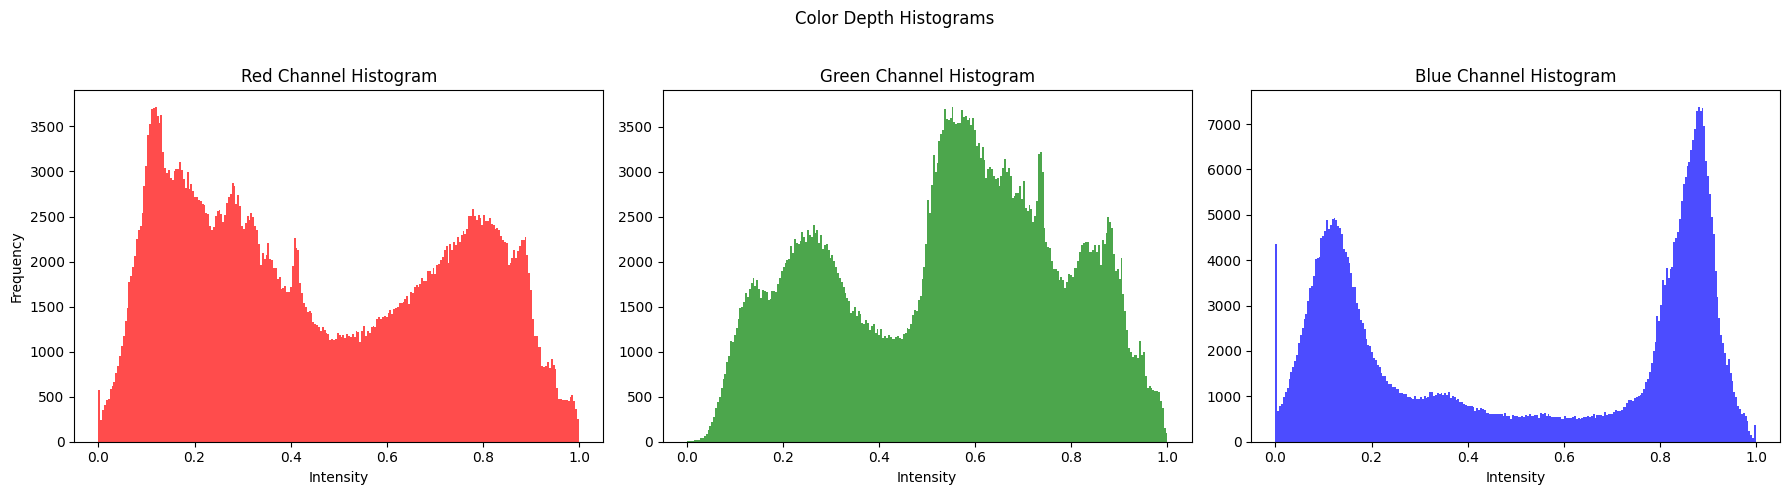

Статистические параметры каналов (интенсивности в диапазоне 0-255, если исходное было uint8):
Channel R: Mean = 0.46, Std. Dev. = 0.28
Channel G: Mean = 0.54, Std. Dev. = 0.24
Channel B: Mean = 0.51, Std. Dev. = 0.34


In [11]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
# Используем .ravel() для преобразования 2D массива в 1D для гистограммы
# Если значения нормализованы к [0,1], умножаем на 255 для стандартного диапазона интенсивностей
plt.hist(R_channel.ravel() * (255 if img.dtype == np.uint8 else 1), bins=256, color='red', alpha=0.7,
         range=(0, 255 if img.dtype == np.uint8 else 1))
plt.title('Red Channel Histogram')
plt.xlabel('Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(G_channel.ravel() * (255 if img.dtype == np.uint8 else 1), bins=256, color='green', alpha=0.7,
         range=(0, 255 if img.dtype == np.uint8 else 1))
plt.title('Green Channel Histogram')
plt.xlabel('Intensity')

plt.subplot(1, 3, 3)
plt.hist(B_channel.ravel() * (255 if img.dtype == np.uint8 else 1), bins=256, color='blue', alpha=0.7,
         range=(0, 255 if img.dtype == np.uint8 else 1))
plt.title('Blue Channel Histogram')
plt.xlabel('Intensity')

plt.suptitle('Color Depth Histograms')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Расчет среднего и стандартного отклонения
params_hist = {}
print("Статистические параметры каналов (интенсивности в диапазоне 0-255, если исходное было uint8):")
for name, channel_matrix in channels.items():
    data_for_hist = channel_matrix.ravel()
    if img.dtype == np.uint8:  # Если исходное было uint8, мы делили на 255
        data_for_hist = data_for_hist * 255

    mean_val = np.mean(data_for_hist)
    std_dev = np.std(data_for_hist)
    params_hist[name] = {'mean': mean_val, 'std': std_dev}
    print(f"Channel {name}: Mean = {mean_val:.2f}, Std. Dev. = {std_dev:.2f}")

**Связь параметров распределения (гистограмм) с числом сингулярных чисел (k), достаточным для восстановления:**

1.  **Стандартное отклонение (Std. Dev.):**
    *   Большее стандартное отклонение обычно означает большее разнообразие интенсивностей в канале, что может указывать на более сложную структуру изображения (больше деталей, перепадов яркости).
    *   Изображения (или их каналы) с высоким Std. Dev. (широкой гистограммой) могут требовать большего числа сингулярных компонент ($k$) для адекватного восстановления, так как в них больше "информации" или "вариативности", которую нужно захватить.
    *   Если Std. Dev. мало (например, почти монохромное изображение или канал с низким контрастом, узкая гистограмма), то меньшее $k$ может быть достаточным, так как значительная часть информации может быть представлена небольшим числом доминирующих компонент.

2.  **Среднее значение (Mean):**
    *   Среднее значение само по себе меньше влияет на выбор $k$, чем Std. Dev. Оно просто показывает общую яркость или "смещение" интенсивностей канала.
    *   Однако, форма гистограммы (не только ее ширина, но и количество пиков) также важна. Если гистограмма имеет несколько выраженных пиков (мультимодальная), это также может указывать на сложную структуру с различными характерными уровнями яркости, что потенциально требует большего $k$ для точного представления всех этих мод.

**Оценка $k$ из пункта 3 и параметры гистограмм:**

Ранее мы предположили, что для визуально приемлемого качества может потребоваться $k \approx 50$ (или значение, полученное экспериментально).
Стандартные отклонения для каналов изображения 'bavarskie_alpi.jpg' (которое содержит разнообразные цвета, тени и светлые участки) оказалось относительно высокими, это согласуется с необходимостью использования нескольких десятков сингулярных компонент для хорошего восстановления. Гистограммы с широким разбросом или несколькими пиками подтверждают это наблюдение.
Напротив, если бы изображение было, например, сильно затуманенным с очень низким контрастом, Std. Dev. для всех каналов было бы низким, и, вероятно, меньшее количество сингулярных чисел ($k$) дало бы удовлетворительный результат.

Таким образом, анализ гистограмм может дать качественное представление о сложности изображения и, косвенно, о том, насколько быстро будут убывать сингулярные числа и сколько их может понадобиться для восстановления.

# Выводы
В ходе практической работы я освоил описанные методы и понял, когда они наиболее эффективны. Для демонстрации выбрал изображение природы, так как оно богато цветами и наглядно. 